# Human in the Loop


In [1]:
import functools
import operator
from typing import Annotated, Sequence, TypedDict

from dotenv import load_dotenv
from langchain.agents import AgentExecutor, create_openai_tools_agent
from langchain.output_parsers.openai_functions import JsonOutputFunctionsParser
from langchain.tools import tool
from langchain_community.chat_models.litellm import ChatLiteLLM
from langchain_community.tools.ddg_search.tool import DuckDuckGoSearchRun
from langchain_core.messages import BaseMessage
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder
from langchain_openai import ChatOpenAI
from langgraph.graph import END, StateGraph

#

load_dotenv()

True

In [2]:
tools = [DuckDuckGoSearchRun()]

In [3]:
from langgraph.prebuilt import ToolExecutor

tool_executor = ToolExecutor(tools)

In [4]:
from langchain_openai import ChatOpenAI

# We will set streaming=True so that we can stream tokens
# See the streaming section for more information on this.
model = ChatOpenAI(temperature=0, streaming=True)

In [5]:
from langchain_core.utils.function_calling import convert_to_openai_function

functions = [convert_to_openai_function(t) for t in tools]
model = model.bind_functions(functions)

In [6]:
import json

from langchain_core.messages import FunctionMessage
from langgraph.prebuilt import ToolInvocation


# Define the function that determines whether to continue or not
def should_continue(messages):
    last_message = messages[-1]
    # If there is no function call, then we finish
    if "function_call" not in last_message.additional_kwargs:
        return "end"
    # Otherwise if there is, we continue
    else:
        return "continue"


# Define the function that calls the model
def call_model(messages):
    response = model.invoke(messages)
    # We return a list, because this will get added to the existing list
    return response


# Define the function to execute tools
def call_tool(messages):
    # Based on the continue condition
    # we know the last message involves a function call
    last_message = messages[-1]
    # We construct an ToolInvocation from the function_call
    action = ToolInvocation(
        tool=last_message.additional_kwargs["function_call"]["name"],
        tool_input=json.loads(
            last_message.additional_kwargs["function_call"]["arguments"]
        ),
    )
    # We call the tool_executor and get back a response
    response = tool_executor.invoke(action)
    # We use the response to create a FunctionMessage
    function_message = FunctionMessage(content=str(response), name=action.tool)
    # We return a list, because this will get added to the existing list
    return function_message

In [7]:
from langgraph.graph import END, MessageGraph

# Define a new graph
workflow = MessageGraph()

# Define the two nodes we will cycle between
workflow.add_node("agent", call_model)
workflow.add_node("action", call_tool)

# Set the entrypoint as `agent`
# This means that this node is the first one called
workflow.set_entry_point("agent")

# We now add a conditional edge
workflow.add_conditional_edges(
    # First, we define the start node. We use `agent`.
    # This means these are the edges taken after the `agent` node is called.
    "agent",
    # Next, we pass in the function that will determine which node is called next.
    should_continue,
    # Finally we pass in a mapping.
    # The keys are strings, and the values are other nodes.
    # END is a special node marking that the graph should finish.
    # What will happen is we will call `should_continue`, and then the output of that
    # will be matched against the keys in this mapping.
    # Based on which one it matches, that node will then be called.
    {
        # If `tools`, then we call the tool node.
        "continue": "action",
        # Otherwise we finish.
        "end": END,
    },
)

# We now add a normal edge from `tools` to `agent`.
# This means that after `tools` is called, `agent` node is called next.
workflow.add_edge("action", "agent")

In [8]:
from langgraph.checkpoint.sqlite import SqliteSaver

memory = SqliteSaver.from_conn_string(":memory:")

In [9]:
# Finally, we compile it!
# This compiles it into a LangChain Runnable,
# meaning you can use it as you would any other runnable
app = workflow.compile(checkpointer=memory, interrupt_before=["action"])

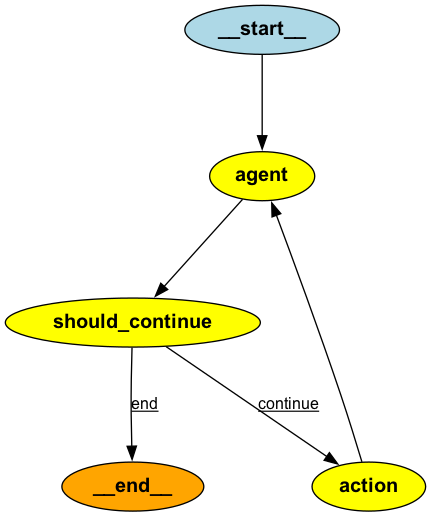

In [11]:
from IPython.display import Image

Image(app.get_graph().draw_png())

In [12]:
from langchain_core.messages import HumanMessage

thread = {"configurable": {"thread_id": "2"}}
inputs = [HumanMessage(content="hi! I'm bob")]
for event in app.stream(inputs, thread):
    for v in event.values():
        print(v)

content='Hello Bob! How can I assist you today?' response_metadata={'finish_reason': 'stop'} id='run-d096b5fe-bd25-4372-aa0a-938b4b37e714-0'


In [13]:
inputs = [HumanMessage(content="what is my name?")]
for event in app.stream(inputs, thread):
    for v in event.values():
        print(v)

content='Your name is Bob! How can I help you, Bob?' response_metadata={'finish_reason': 'stop'} id='run-9d7bab6d-7ce5-436d-92d4-ad6593f70f1d-0'


In [14]:
inputs = [HumanMessage(content="what's the weather in sf now?")]
for event in app.stream(inputs, thread):
    for v in event.values():
        print(v)

content='' additional_kwargs={'function_call': {'arguments': '{"query":"weather in San Francisco now"}', 'name': 'duckduckgo_search'}} response_metadata={'finish_reason': 'function_call'} id='run-08edb5e9-ca1e-4fd7-8736-973d859e6e2a-0'


In [15]:
for event in app.stream(None, thread):
    for v in event.values():
        print(v)

content="Weather.gov > San Francisco Bay Area, CA. Current Hazards. Current Conditions. Radar. Forecasts. Rivers and Lakes. Climate and Past Weather. Local Programs. Click a location below for detailed forecast. Today's and tonight's professional weather forecast for San Francisco. Precipitation radar, HD satellite images, and current weather warnings, hourly temperature, chance of rain, and sunshine hours. Everything you need to know about today's weather in San Francisco International Airport, CA. High/Low, Precipitation Chances, Sunrise/Sunset, and today's Temperature History. First Alert Weather Sunday morning forecast 4-21-24. Brian Hackney says temperatures will inch up Monday before a cooling trend and possible rain later in the week. 3H ago. 02:34. South San Francisco Weather Forecasts. Weather Underground provides local & long-range weather forecasts, weatherreports, maps & tropical weather conditions for the South San Francisco area." name='duckduckgo_search' id='3ffcfc33-7d5